In [1010]:
import osqp
import cvxpy as cp
import numpy as np

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.linalg import hankel

import gym
import mujoco_py
from gym import wrappers
from IPython import display
plt.rcParams["figure.figsize"] = (18,6)
%matplotlib inline

## Data Collection

In [1011]:
env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
"""
    Timestep for InvertedPendelum-v4 is 0.02
"""
obs, info = env.reset()
ud = np.array([0])
yd = obs
done = False
start = True

Tini = 4
n = 4
N = 5
m = 1
p = 4
T = (m+1)*(Tini + N + n) - 1

render_collection = False

for i in range(T):
    action = env.action_space.sample()
    # action = np.random.uniform(low=-0.5, high=0.5, size=(m,))
    obs, rew, done, info, _ = env.step(action)
    if not start:
        obs = obs + np.random.uniform(low=-0.01, high=0.01, size=(p,))
    start = False

    if render_collection:
        plt.title(f"Action {action[0]:.3f} Iter {i}")
        plt.imshow(env.render())
        display.display(plt.gcf())    
        display.clear_output(wait=True)

    ud = np.append(ud,action)
    yd = np.append(yd,obs)

env.close()
T = T+1
print(f'yd shape : {yd.shape}   ud shape : {ud.shape}')


yd shape : (104,)   ud shape : (26,)


In [1012]:
L = Tini + N + n
H = hankel(ud[0:L], ud[L-1:])
print(f'H has rank {np.linalg.matrix_rank(H)} and shape {H.shape}')

H has rank 13 and shape (13, 14)


In [1013]:
L = Tini + N

U = hankel(ud[0:L], ud[L-1:])

Y = np.zeros((L*p, T-L+1))
for i in range(0,T-L+1):
    Y[:,i] = yd[p*i:p*(L+i)]

Up = U[0:Tini, :]
Uf = U[Tini:, :]
print(f'U = {U.shape}, Up = {Up.shape}, Uf = {Uf.shape}')

Yp = Y[0:p*Tini, :]
Yf = Y[p*Tini:, :]
print(f'Y = {Y.shape}, Yp = {Yp.shape}, Yf = {Yf.shape}')

u_ini = ud[:Tini]
y_ini = yd[:p*Tini]
print(f'u ini : {u_ini}\ny ini : {y_ini}')


U = (9, 18), Up = (4, 18), Uf = (5, 18)
Y = (36, 18), Yp = (16, 18), Yf = (20, 18)
u ini : [ 0.         -2.19508862 -0.06982227  2.17334104]
y ini : [ 3.94919197e-04 -4.74892570e-03 -4.26663309e-03 -8.26466597e-03
 -1.43705840e-02  2.85821601e-02 -7.31984969e-01  1.65775729e+00
 -4.83386858e-02  8.53666597e-02 -7.42058742e-01  1.64062707e+00
 -6.81798932e-02  1.33311679e-01 -3.53666471e-02  3.41236829e-02]


## Solver

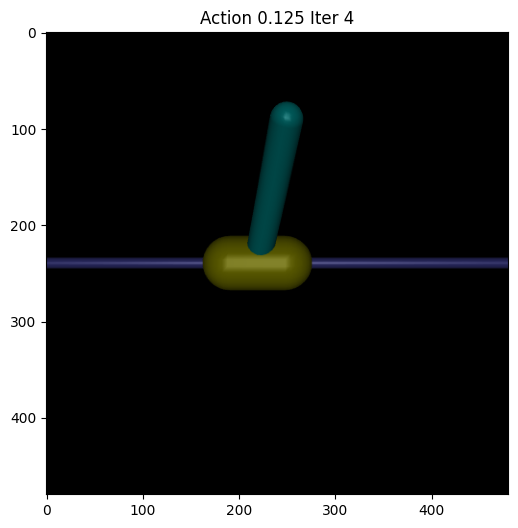

In [1014]:
g = cp.Variable(T - Tini - N + 1)
u = cp.Variable(N)
y = cp.Variable(N*p)
sig_y = cp.Variable(p*Tini)#

Q = np.diag([1,100,1,1])
Q = np.kron(np.eye(N), Q)
R = np.eye(N)

cost = cp.quad_form(y, Q) + cp.quad_form(u,R) + cp.norm(g,1)*100 #+ cp.norm(sig_y, 1)*10000

env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
env._max_episode_steps = 100
obs = env.reset()
yT = [*y_ini]
uT = [*u_ini]
done = False
iter = 0
render_solution = True

while not done:

  constraints = [
    Up @ g == u_ini,
    Yp @ g == y_ini,# + sig_y,
    Uf @ g == u,
    Yf @ g == y,
    cp.abs(u) <= 3
  ]

  prob = cp.Problem(cp.Minimize(cost), constraints)
  prob.solve(solver=cp.ECOS, verbose=False)
  action = prob.variables()[1].value[0]

  if render_solution:
    plt.title(f"Action {action:.3f} Iter {iter}")
    plt.imshow(env.render())
    display.display(plt.gcf())    
    display.clear_output(wait=True)
  
  obs,_,done,_,_ = env.step([action])
  obs = obs + np.random.uniform(low=-0.01, high=0.01, size=(p,))
  yT = np.append(yT, obs)
  uT = np.append(uT, action)
    
  u_ini = uT[-Tini:]
  y_ini = yT[-p*Tini:]
  iter += 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


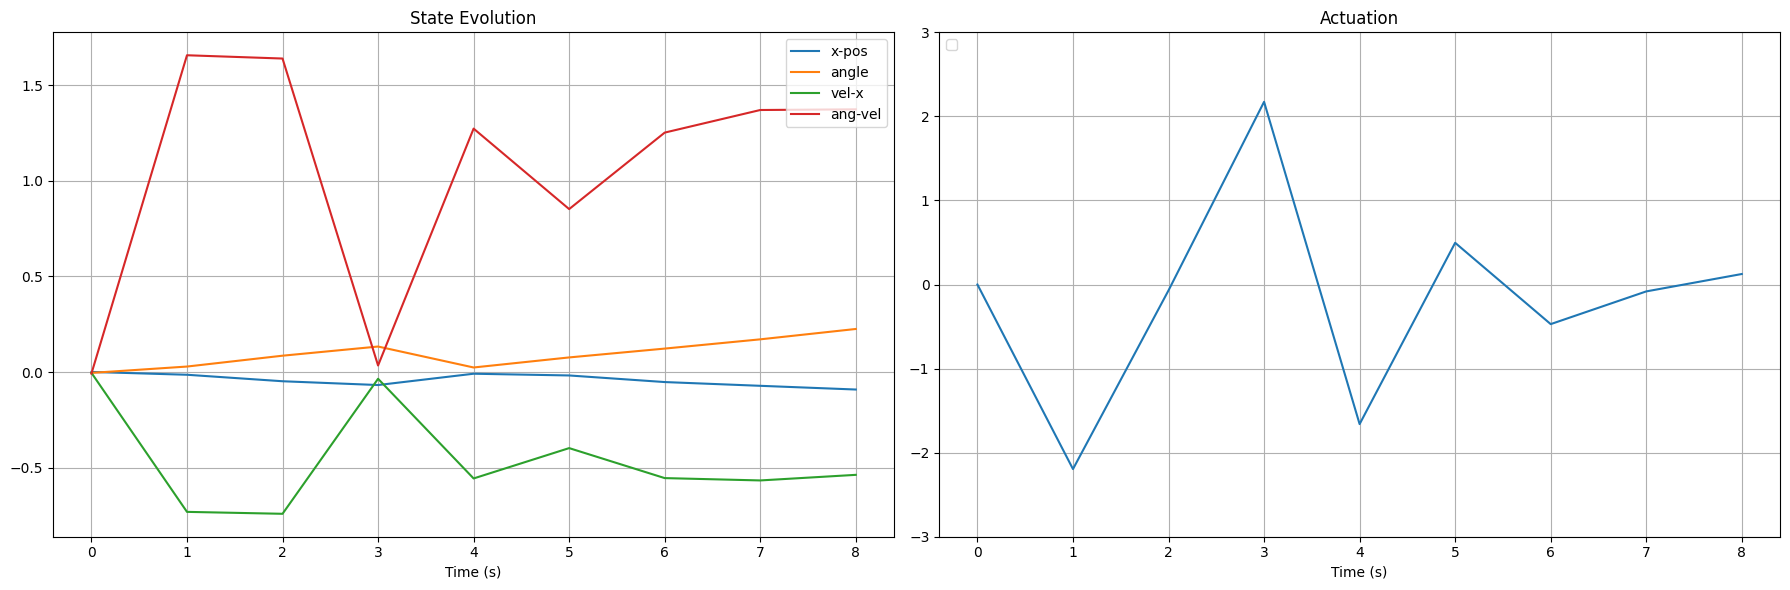

In [1015]:
T = len(uT)
yT = yT.reshape((T,4))

plt.subplot(1,2,1)
plt.plot(range(0,T), yT, label=['x-pos', 'angle', 'vel-x', 'ang-vel'])
plt.legend(loc="upper right")
plt.xlabel('Time (s)')
plt.title("State Evolution")
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,T), uT)
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.title("Actuation")
plt.ylim((-3,3))
plt.grid('on')
plt.tight_layout()

plt.show()